In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [6]:
# Load dataset and separate labeled and unlabeled data
dataset = pd.read_csv('data/train.csv')
labeled_data = dataset[dataset['Score'].notna()]
unlabeled_data = dataset[dataset['Score'].isna()]

# Perform TF-IDF vectorization on the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_labeled = tfidf_vectorizer.fit_transform(labeled_data['Text'].fillna(""))



In [7]:
# Function to extract sentiment scores using TextBlob
def extract_sentiment_features(text):
    blob = TextBlob(text)
    return {'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity}

# Apply sentiment extraction to training and testing text data
sentiment_labeled = labeled_data['Text'].fillna("").apply(lambda x: extract_sentiment_features(str(x)))
sentiment_df_labeled = pd.DataFrame(list(sentiment_labeled))

sentiment_unlabeled = unlabeled_data['Text'].fillna("").apply(lambda x: extract_sentiment_features(str(x)))
sentiment_df_unlabeled = pd.DataFrame(list(sentiment_unlabeled))


In [8]:
# Combine text and sentiment features for labeled data
X_features_labeled = hstack((X_text_labeled, sentiment_df_labeled[['polarity', 'subjectivity']].values))

# Split labeled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_features_labeled,
    labeled_data['Score'],
    test_size=0.2,
    random_state=42
)

# Train Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, n_jobs=-1)
model.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=-1)

Validation Accuracy: 0.64
              precision    recall  f1-score   support

         1.0       0.59      0.56      0.58     18074
         2.0       0.41      0.25      0.31     17604
         3.0       0.45      0.35      0.39     35179
         4.0       0.48      0.32      0.39     67127
         5.0       0.73      0.90      0.80    159085

    accuracy                           0.64    297069
   macro avg       0.53      0.48      0.49    297069
weighted avg       0.61      0.64      0.62    297069



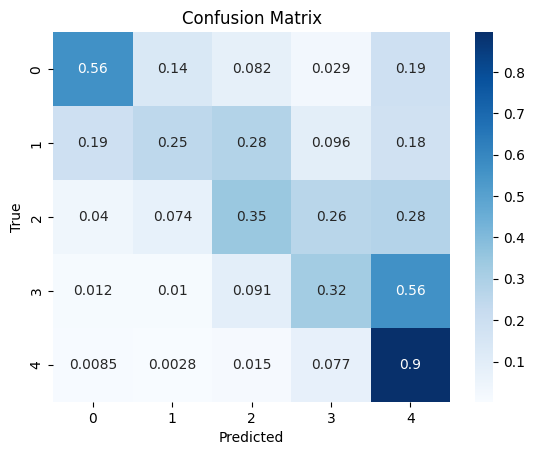

In [9]:
# Validate model and display metrics
y_val_pred = model.predict(X_val)
print(f'Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}')
print(classification_report(y_val, y_val_pred))

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred, normalize='true')
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Prepare submission file with predictions for unlabeled data
predictions_unlabeled = model.predict(hstack((tfidf_vectorizer.transform(unlabeled_data['Text'].fillna("")),
                                              sentiment_df_unlabeled[['polarity', 'subjectivity']].values)))
submission = pd.DataFrame({'Id': unlabeled_data['Id'], 'Score': predictions_unlabeled})
submission.to_csv("./data/submission.csv", index=False)

In [10]:
import pandas as pd

# Load the submission file
submission_df = pd.read_csv('data/submission.csv')  # Adjust the path as necessary


# Calculate the number of 4.0 scores to randomly change (0.01% of the remaining 4.0s)
num_to_change = int((submission_df['Score'] == 4.0).sum() * 0.0001)  # 0.01% is 0.0001

# Check if there are enough 4.0 scores to change
if num_to_change > 0:
    # Randomly select indices of the 4.0 scores to change
    indices_to_change = submission_df[submission_df['Score'] == 4.0].sample(n=num_to_change, random_state=42).index
    
    # Change selected scores from 4.0 to 5.0
    submission_df.loc[indices_to_change, 'Score'] = 5.0

# Define the specific Ids where 5.0 scores should change to 4.0
ids_to_change = [
    286870, 1471088, 500068, 1262261, 950720, 935207, 478809, 542803,
    1196255, 1558691, 705167, 108246, 643223, 227694, 863582, 202518,
    415575, 1339167, 145871, 1624276, 214123, 460909, 656473, 471374,
    640402, 298918, 685413, 1510748, 1293030
]

# Apply the changes to switch these scores from 5.0 to 4.0 for specified Ids
submission_df.loc[submission_df['Id'].isin(ids_to_change) & (submission_df['Score'] == 4.0), 'Score'] = 5.0

# Save the modified DataFrame to a new CSV file
submission_df.to_csv('final_submission.csv', index=False)  # Adjust the path as necessary

